# Demonstration and unit-testing `ri_ci` for Matlab

This file was tested on Matlab version 2019b, using the Jupyter `matlab_kernel`.

###  Matlab preliminaries

In [3]:
rng('default'); % set seed for replicability
addpath('../m'); % assumes we are in the /demo/ folder as pwd

In [4]:
%  Parameters of the simulation
N = 1000; % number of observations
R = 500 ; % number of alternative permutations of the treatment assignment to be used
tau = 1 ; % treatment effect

In [ ]:
%  Generate data 
x = randn(N,1);
y0 = x + randn(N,1);
y1 = y0 + tau;
t = (rand(N,1) >= 0.5 ) ; % treatment status
y = y0 + t.*(y1 - y0) ; % switching regression
T0 = (rand(N,R) >= 0.5) ; % set of potential randomizations
DATA = array2table([y,t,x] , 'VariableNames',{'y','t','x'});

##  Testing specific sharp nulls

###  Testing null that $\tau_0 = 0$

In [ ]:
clear ri_ci
tau0 = 0;
[pval t1 t0] = ri_ci(DATA,{'y'},{'t'},tau0, T0, R ,'ShowMainEstimates',true);
%scatter(y0,y0star) % confirm this recovers the true y0

figure(1)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
legend('Distribution under null','Estimated test statistic')
hold off

Illustrating one-sided versions of this hypothesis:

In [ ]:
clear ri_ci
leftprob = ri_ci(DATA,{'y'},{'t'},0, T0, 100,'TestSide','lefttail')
rightprob = ri_ci(DATA,{'y'},{'t'},0, T0, 100,'TestSide','righttail')

###  Testing sharp nulls of non-zero treatment effects (e.g., $\tau_0=1$)

_Note:_  Model displays primary estimates that are the basis of analytic standard errors; p-values in that table correspond to test that $\tau_0=0$.

In [ ]:
clear ri_ci
tau0 = 1;
[pval t1 t0] = ri_ci(DATA,{'y'},{'t'},tau0, T0, 100);
%scatter(y0,y0star) % confirm this recovers the true y0

figure(2)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
legend('Distribution under null','Estimated test statistic')
hold off

## Finding 95% confidence interval

In [ ]:
clear ri_ci
tau0 = 0;
tic
[pval ,~,~,~,CI ,Q_UB, Q_LB ] = ri_ci(DATA,{'y'},{'t'},tau0, T0, R ,'FindCI',true);
toc

pval
CI 

In [ ]:
[Q_UB, Q_LB]

In [ ]:
figure(3)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

## Functionality with estimation commands other than `lm()`

When using estimation commands other than `lm()`, we will use 10 times the asymptotic confidence interval for OLS, assuming independent and homoskedastic errors, to define the search region, if the search region is not supplied by the user.

###  Use with `rereg()` for random effects.

To demonstrate how this can be used with `rereg()`, we will simluate data with cluster-randomized assignment.  Let there be groups $g=1,\ldots,G$, with $G=200$, and observations indexed by $\{ig\}$ with $n=5$ observations per group.

Let $y_{0,ig} = e_{0,g} + e_{0,ig}$ with each error term $\sim N(0,1)$.

Let the treatment effect, $\tau=1$, and $y_{1,ig}=y_{0,ig}+\tau$ for all $i,g$.

Observed outcomes are given by the _switching regression_ $y_{ig} = y_{0,ig} + (y_{1,ig} - y_{0,ig})  t_{ig} = y_{0,ig} + \tau t_{ig}$

In [21]:
R = 500 ; % number of alternative permutations of the treatment assignment to be usedtau = 1 ;
const = 10 ; 
G=200;  % number of clusters
n=5;    % number of observations/cluster
t = (rand(G,1) >= 0.5 ) ; % treatment status
T0 = (rand(G,R) >= 0.5) ; % set of potential randomizations
x_g = randn(G,1) ; % observable at cluster level
e_0g = randn(G,1) ; % error term at cluster level
g = [1:G]';  % group index

%  Expand all group-level datasets to the individual level
t = kron(t,ones(n,1));
T0 = kron(T0,ones(n,1));
e_0g = kron(e_0g,ones(n,1));
x_g = kron(x_g,ones(n,1));
g = kron(g,ones(n,1));

%  constant additive treatment effect
tau = 1; 

%  remainder of DGP at individual level
e_0i = randn(G*n,1);
x_i = randn(G*n,1);
y0 = const + x_g + x_i + e_0g + e_0i ;
y1 = y0 + tau ;
y = y0 + tau * t;

%  Data to table, for passing to rereg.
D = array2table([y,t,x_i,x_g,g],'VariableNames',{'y' 't' 'x_i' 'x_g' 'g'});

**Demonstrating use of `rereg()`**.  Note that this estimator, as programmed, uses cluster-robust standard errors and makes a degrees-of-freedom correction to the variance-covariance matrix, as discussed in Greene (eq. 11.3).

In [16]:
clear rereg
lm = fitlm(D,'y~ t + x_i + x_g') % ([t x_g x_i ],y)
%beta_re = rereg(y,[t , x_g, x_i],g)  % <- ols syntax:  assumes data are in arrays rather than tables.
re = rereg(D,{'y'},{'t' 'x_i' 'x_g'},{'g'})


lm = 


Linear regression model:
    y ~ 1 + t + x_i + x_g

Estimated Coefficients:
                   Estimate        SE        tStat        pValue   
                   _________    ________    ________    ___________

    (Intercept)       10.101    0.054664      184.79              0
    t              0.0051798    0.082545    0.062751        0.94998
    x_i               1.0397    0.040398      25.736    2.1561e-112
    x_g              0.93816    0.040617      23.097     7.2355e-95


Number of observations: 1000, Error degrees of freedom: 996
Root Mean Squared Error: 1.29
R-squared: 0.547,  Adjusted R-Squared: 0.546
F-statistic vs. constant model: 401, p-value = 8.02e-171

re =

  4x3 table

                  beta          SE        tStat  
                _________    ________    ________

    Constant       10.102     0.09848      102.58
    t           0.0037693     0.13999    0.026925
    x_i            1.0189    0.031458      32.389
    x_g            0.9382    0.070318    

**Demonstrate use of `ri_ci()` to obtain p-values for test of zero null with random effects estimation via `rereg`**

In [17]:
clear rereg
clear ri_ci
tic
pval = ri_ci(D,{'y'},{'t'},0, T0, R,'Model','rereg','GroupVar',{'g'} )
toc


result =

  2x3 table

                  beta        SE        tStat  
                ________    _______    ________

    Constant      10.187     0.1426      71.442
    t           -0.18987    0.20696    -0.91745


pval =

    0.3160

Elapsed time is 14.996889 seconds.



**Demonstrate use of `ri_ci()` to obtain confidence intervals with random effects estimation via `rereg`.**

In [22]:
clear ri_ci
tau0 = 0 ;
tic
[pval ,~,~,~,CI ,Q_UB, Q_LB ] = ri_ci(D,{'y'},{'t'},tau0, T0, R ...
    , 'Model', 'rereg', 'GroupVar',{'g'} ...
    ,'FindCI',true ...
    , 'TestZero', false ... % don't bother with p-value for tau=0
    );
toc

pval
CI 


result =

  2x3 table

                 beta       SE       tStat 
                ______    _______    ______

    Constant    10.021    0.16344    61.314
    t            1.127    0.23019    4.8961

Elapsed time is 350.090129 seconds.

pval =

     0


CI =

    0.6380    1.5544





ans =

    3.3829         0   -1.1288         0
    2.2550         0   -0.0009         0
    1.6910    0.0120    0.5631         0
    1.4090    0.1800    0.8451    0.2080
    1.5500    0.0320    0.7041    0.0520
    1.6205    0.0160    0.6336    0.0200
    1.5853    0.0200    0.6688    0.0360
    1.5676    0.0200    0.6512    0.0280
    1.5588    0.0240    0.6424    0.0280
    1.5544    0.0280    0.6380    0.0280




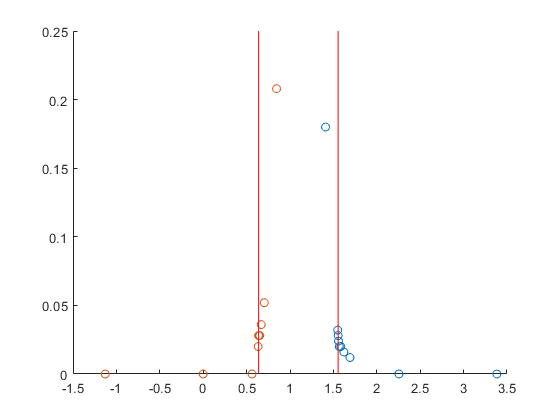

In [24]:
[Q_UB, Q_LB]
figure(4)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

### Use with `kstest()` for Kolmogorov-Smirnov test statistic

In [26]:
clear ri_ci
tau0 = 0 ;
tic
[pval ,~,~,~,CI ,Q_UB, Q_LB ] = ri_ci(D,{'y'},{'t'},tau0, T0, R ...
    , 'Model', 'ks', ...
    , 'FindCI', false ...
    , 'TestZero', true ... 
    );
toc

Error: Invalid expression. When calling a function or indexing a variable, use parentheses. Otherwise, check for mismatched delimiters.



Error: -1

In [ ]:

clear ri_ci
tau0 = 0 ;
tic
[pval ,~,~,~,CI,Q_UB,Q_LB] = ri_ci(D,{'y'},{'t'},tau0, T0, R ...
    , 'Model', 'ks' ...
    , 'TestZero', true ... % don't bother with p-value for tau=0
    , 'FindCI', true ...
    );  % ,~,~,~,CI ,Q_UB, Q_LB 
toc

In [ ]:
[Q_UB, Q_LB]

figure(5)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off